In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

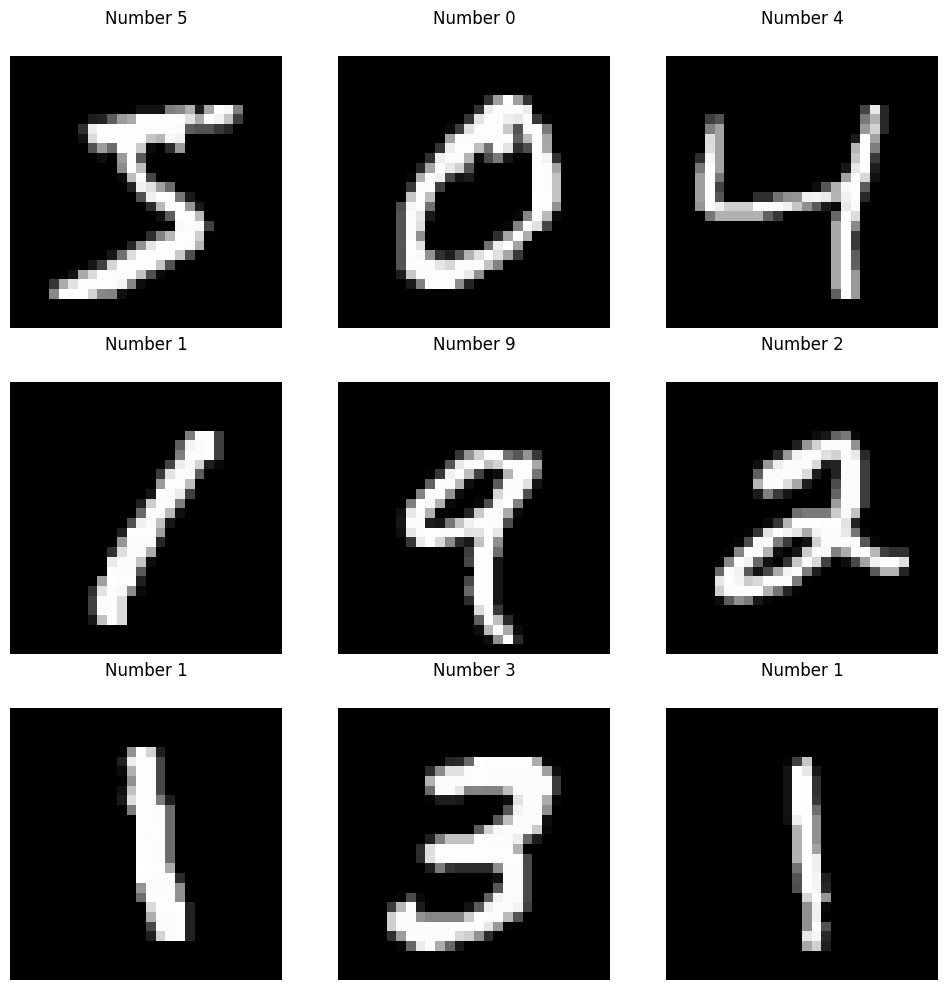

In [5]:
# Create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12)) # 3x3 Grid
plt.gray()

# Loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

In [6]:
# Preprocessing the images

# Convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1) #Flatten each 28x28 image into a 1D array (784 pixels).
Y = y_train

# Normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [7]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits) # 10 Clusters

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [8]:
kmeans.labels_

array([4, 3, 2, ..., 6, 8, 9], dtype=int32)

### Infer cluster & data labels 
These two functions work together to map the clusters created by the KMeans algorithm to the actual labels of the data (e.g., digits 0–9 in the MNIST dataset). They bridge the gap between unsupervised clustering (where clusters are unlabeled) and supervised evaluation (where we have ground truth labels).

In [9]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # Find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # Append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # Code below:
        # Purpose: Count the occurrences of each true label within the cluster using np.bincount.
        # Example: If labels = [2, 2, 3, 3, 3], then counts = [0, 0, 2, 3].

        """
        Suppose there are 3 clusters, and these clusters contain the following true labels:
        Cluster 0: [1, 1, 1, 2, 2]
        Cluster 1: [0, 0, 0, 1]
        Cluster 2: [2, 2, 2, 3]
        The inferred labels dictionary will look like:
            {
                1: [0],  # Most frequent label in cluster 0 is 1.
                0: [1],  # Most frequent label in cluster 1 is 0.
                2: [2]   # Most frequent label in cluster 2 is 2.
            }
        """
        
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # Assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

In [10]:
def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # Empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [11]:
# Evaluate cluster performance
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[3 0 4 1 8 2 1 3 1 8 3 1 3 6 1 7 2 1 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [12]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [13]:
clusters = [10, 16, 36, 64, 144, 256, 1024, 2048]

# Test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)
    
    # Print cluster metrics
    calculate_metrics(estimator, X, Y)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # Calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2372827.1897670333
Homogeneity: 0.46543840373852374
Accuracy: 0.5646333333333333

Number of Clusters: 16
Inertia: 2215546.682479308
Homogeneity: 0.560947680382237
Accuracy: 0.6595166666666666

Number of Clusters: 36
Inertia: 1955998.9431867367
Homogeneity: 0.6909142326851307
Accuracy: 0.7601333333333333

Number of Clusters: 64
Inertia: 1812892.597665421
Homogeneity: 0.7325216070956357
Accuracy: 0.7990333333333334

Number of Clusters: 144
Inertia: 1628003.491484164
Homogeneity: 0.8072150531874053
Accuracy: 0.8693666666666666

Number of Clusters: 256
Inertia: 1501690.8357727213
Homogeneity: 0.8482056620473788
Accuracy: 0.9032166666666667

Number of Clusters: 1024
Inertia: 1261452.790828953
Homogeneity: 0.9008500424664346
Accuracy: 0.93245

Number of Clusters: 2048
Inertia: 1136923.453374164
Homogeneity: 0.9241447520847861
Accuracy: 0.9459166666666666



In [14]:
# Test kmeans algorithm on testing dataset
# Convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# Normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# Initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# Predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# Calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.9048



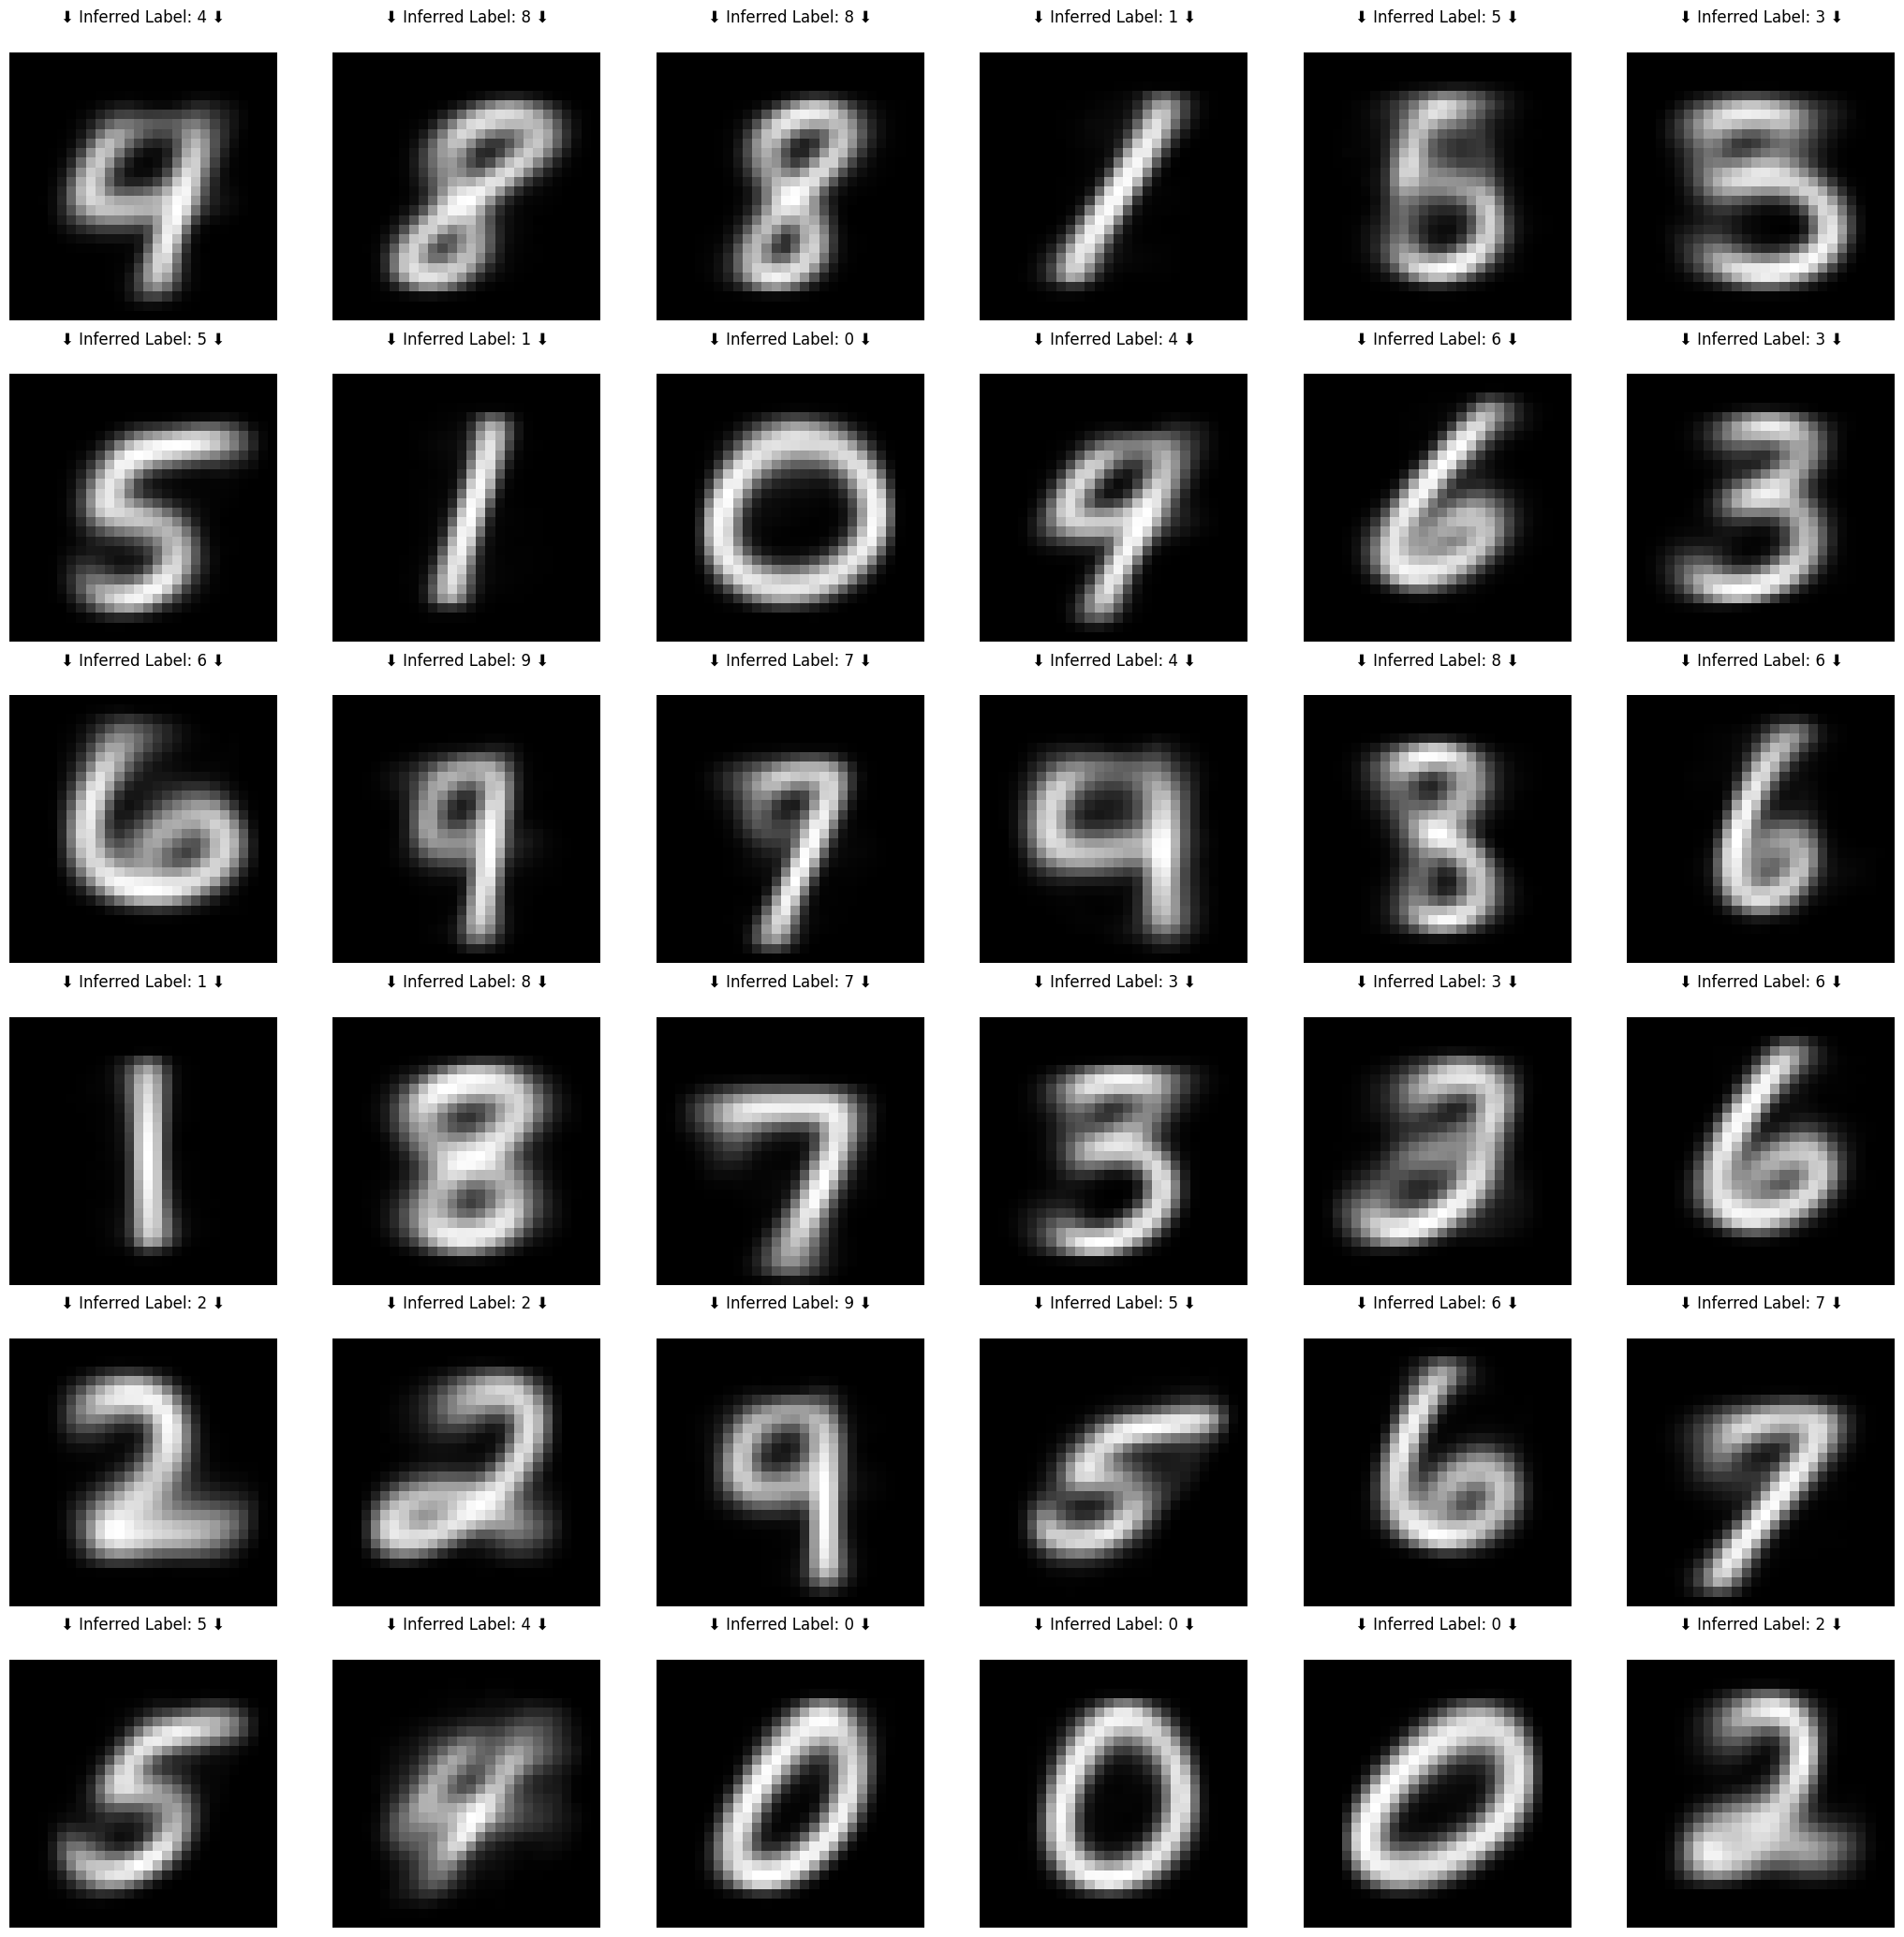

In [26]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# Record centroid values
centroids = kmeans.cluster_centers_

# Reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# Determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# Create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (26, 26))
plt.gray()

# Loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('⬇ Inferred Label: {} ⬇'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# Display the figure
fig.show()